# HSE 2021: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [2]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net). 

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$.

The optimization problem with respect to the $w_0, w$ is the following (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format) 

$$\nabla_w L(w, w_0)= - \frac{1}{N} \cdot \sum_{ i = 1 } ^ N \frac{ e ^ { -y_i ( w^Tx_i + w_0 ) } } { 1 + e ^ { -y_i ( w^Tx_i + w_0 ) } } \cdot y_i  x_i + \gamma sign(w) + 2 \beta w $$

$$\nabla_{ w_0 } L(w, w_0)= - \frac{1}{N} \cdot \sum_{ i = 1 } ^ N \frac{ e ^ { -y_i (w^Tx_i + w_0) } } { 1 + e^{-y_i (w^Tx_i + w_0) } } \cdot y_i $$

#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [27]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    right = beta * np.linalg.norm(w) + gamma * np.sum(np.abs(w))
    left = np.sum(1 + np.exp(-y * np.dot(X, np.transpose(w)) + w0))
    return 1. / X.shape[0] * left + right

#### 3. [0.25 points] Implement the gradient (as a function)

In [26]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    left = np.exp(-y * (np.dot(X, (np.transpose(w))) + w0))
    right = left + 1
    res = left / right * y 
    grad_w0 = -1. / X.shape[0] * np.sum(res)
    grad_w = -1. / X.shape[0] * np.dot(res, X) + gamma * np.sign(w) + 2 * beta * w
    
    return grad_w, grad_w0

#### Check yourself

In [28]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844, 
                   rtol=1e-2)
)

####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [29]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [53]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        self.beta = beta        
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.learning_rate = lr
        self.random_state = random_state
        
        self.loss_history = []
        self.w0 = 1

        self.__setRandom()
    
        
    def fit(self, X, y):
        self.w = np.ones(X.shape[1])
        
        for i in range(self.max_iter):
            current_loss = loss(X, y, self.w, self.w0, gamma=self.gamma, beta=self.beta)
            self.loss_history.append(current_loss)
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, gamma=self.gamma, beta=self.beta)

            dest = self.w - self.learning_rate * grad_w - self.w
            if np.linalg.norm(dest) < self.tolerance:
                break
                
            self.w -= self.learning_rate * grad_w
            self.w0 -= self.learning_rate * grad_w0
            
        return self
    
    
    def predict(self, X):
        proba = self.predict_proba(X)[1,:] < 0.5
        return np.where(proba, -1, 1)
    

    def predict_proba(self, X):
        first = 1 / (1 + np.exp(np.dot(X, self.w) + self.w0))
        second = 1 / (1 + np.exp(-np.dot(X, self.w) - self.w0))
        return np.array([first, second])
        
    def __setRandom(self):
        np.random.seed(self.random_state)  

In [54]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [55]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    
    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

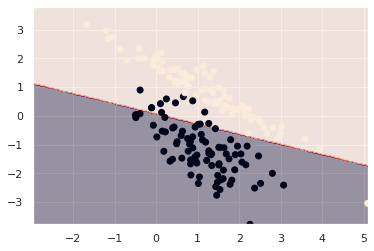

In [56]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

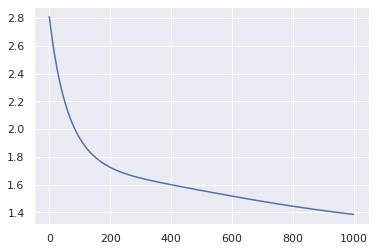

In [57]:
plt.plot(model.loss_history)
plt.show()

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient 

Show how these parameters affect accuracy, roc_auc and f1 score. 
Make plots for the dependencies between metrics and parameters. 
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

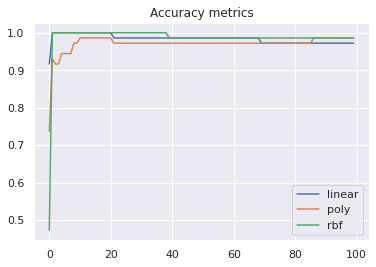

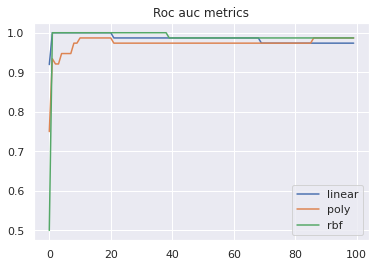

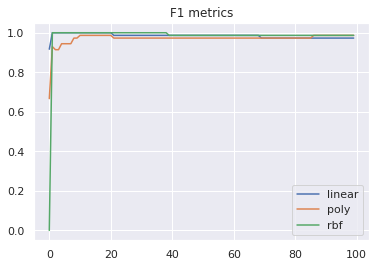

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# Initialize data
linspace = np.linspace(0.01, 10, 100)

kernels = ['linear', 'poly', 'rbf']

accuracy_score_result = [ ]
roc_auc_score_result = [ ]
f1_score_result = [ ]

# Split dataset
X_dataset_train, X_dataset_test, Y_dataset_train, Y_dataset_test = train_test_split(X, y, test_size=0.4, random_state=2)


# Train and predict 
for i in range(0, 3):
    accuracy_score_result.append([ ])
    roc_auc_score_result.append([ ])
    f1_score_result.append([ ])

    for value in linspace:
        clf = SVC(kernel = kernels[i], C = value)
        clf.fit(X_dataset_train, Y_dataset_train)
        Y_predict = clf.predict(X_dataset_test)

        accuracy_score_result[i].append(accuracy_score(Y_dataset_test, Y_predict))
        roc_auc_score_result[i].append(roc_auc_score(Y_dataset_test, Y_predict))
        f1_score_result[i].append(f1_score(Y_dataset_test, Y_predict))

# Accuracy metrics
for i in range(0, 3):
    plt.plot(accuracy_score_result[i], label = kernels[i])

plt.legend()
plt.title('Accuracy metrics')
plt.show()

# Roc auc metrics
for i in range(0, 3):
    plt.plot(roc_auc_score_result[i], label = kernels[i])

plt.legend()
plt.title('Roc auc metrics')
plt.show()

# F1 metrics
for i in range(0, 3):
    plt.plot(f1_score_result[i], label = kernels[i])

plt.legend()
plt.title('F1 metrics')
plt.show()



## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors: 
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center> 
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr> 
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td> 
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td> 
        <tr><td> ... </td><td> ... </td><td> 
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset 
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [69]:
!pip install pymorphy2
import pymorphy2
import tqdm
import glob
import nltk
import string 
from sklearn.utils import shuffle
import numpy as np
import random
import pandas as pd
from nltk import tokenize, download

download('punkt')
download('stopwords')

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Mounted at /content/gdrive


In [73]:
prose_location = 'https://drive.google.com/drive/folders/1cuBdgy8GgXsHC31SZTjNfMpEVAJ9Ewed?usp=share_link'
text_link = '/content/gdrive/MyDrive/poems/'
authors = ['Block', 'Bryusov', 'Chekhov', 'Dostoevsky', 'Gogol', 'Gorky']
sentences = []

def getSentencesFromFile(file):
    with open(file, 'r', encoding='utf8') as f:
        sentences = []
        for s in tokenize.sent_tokenize(f.read()):
            if(len(s.replace('\n', '')) > 14):
                sentences.append(s)
        return sentences

for i in range(len(authors)):
    current_sentences = []
    author_file = text_link + authors[i] + '/*.txt'
    for file in glob.glob(author_file):
        current_sentences += getSentencesFromFile(file)

    sentences.append(current_sentences)
    display(authors[i] + ' ' + str(len(current_sentences)))


'Block 421'

'Bryusov 24320'

'Chekhov 21920'

'Dostoevsky 112349'

'Gogol 23793'

'Gorky 45846'

In [80]:
k = 10
rates = [5 * k, 15 * k, 8 * k, 11 * k, 20 * k, 3 * k]
for i in range(len(sentences)):
    sentences[i] = sentences[i][:(rates[i])]
    display(len(sentences[i]))

50

150

80

110

200

30

In [81]:
union_sentences = []
for i in range(len(authors)):
  for sentence in sentences[i]:
    union_sentences.append((authors[i], sentence))

np.random.shuffle(union_sentences)
dataset = pd.DataFrame(union_sentences, columns = ['Author', 'Sentence'])
dataset

,Author,Sentence
0,Chekhov,"Один из них живет в Париже, два докторами, чет..."
1,Gogol,"Большая разъехавшаяся хата, в которой помещала..."
2,Bryusov,I\n \n \n - Она!
3,Gogol,"Старуха мелким, дробным шагом побежала так быс..."
4,Dostoevsky,"Не люблю, когда при одном лишь общем образован..."
...,...,...
615,Bryusov,Анна Николаевна думала о\n рельефных ангело...
616,Bryusov,"Потом Каролина Густавовна высчитала, что выруч..."
617,Gogol,"Как же можно, чтобы христианские души пропали ..."
618,Gogol,"— Да народ необидчивый: богослов Халява, филос..."


In [82]:
stop_words = nltk.corpus.stopwords.words('russian')
numbers = [str(x) for x in np.arange(0, 10)]
punctuation = string.punctuation + '…' + '–—'
forbidden = list(stop_words) + list(numbers) + list(punctuation)
word_tokenizer = nltk.WordPunctTokenizer()

def adapt(sentence):
    lower = sentence.lower()
    words = word_tokenizer.tokenize(lower)

    adapted = []
    for word in words:
        if (word not in forbidden):
            adapted.append(word)
    return ' '.join(adapted)


def normalize(sentence):
    words = sentence.split(' ')
    normalized = []
    for word in words:
        normal = pymorphy2.MorphAnalyzer().parse(word)[0].normal_form
        normalized.append(normal)
    return ' '.join(normalized)


dataset['Adapted'] = dataset['Sentence'].apply(adapt)
dataset['Normalized'] = dataset['Adapted'].apply(normalize)
dataset

,Author,Sentence,Adapted,Normalized
0,Chekhov,"Один из них живет в Париже, два докторами, чет...",живет париже докторами четвертый художник пяты...,жить париж доктор четвёртый художник пятый гов...
1,Gogol,"Большая разъехавшаяся хата, в которой помещала...",большая разъехавшаяся хата которой помещалась ...,больший разъехаться хата который помещаться бу...
2,Bryusov,I\n \n \n - Она!,i,i
3,Gogol,"Старуха мелким, дробным шагом побежала так быс...",старуха мелким дробным шагом побежала быстро в...,старуха мелкий дробный шаг побежать быстро вса...
4,Dostoevsky,"Не люблю, когда при одном лишь общем образован...",люблю одном лишь общем образовании суются разр...,любить один лишь общий образование соваться ра...
...,...,...,...,...
615,Bryusov,Анна Николаевна думала о\n рельефных ангело...,анна николаевна думала рельефных ангелочках ка...,анна николаевич думать рельефный ангелочек кач...
616,Bryusov,"Потом Каролина Густавовна высчитала, что выруч...",каролина густавовна высчитала выручка каждым м...,каролина густавович высчитать выручка каждый м...
617,Gogol,"Как же можно, чтобы христианские души пропали ...",христианские души пропали,христианский душа пропасть
618,Gogol,"— Да народ необидчивый: богослов Халява, филос...",народ необидчивый богослов халява философ брут...,народ необидчивый богослов халява философ брут...


In [85]:
import sklearn.feature_extraction.text as txt
from sklearn.feature_extraction.text import CountVectorizer

tfidf = txt.TfidfVectorizer()
tfidf_result = tfidf.fit_transform(dataset['Normalized'])
display("TF-IDF:")
print(tfidf_result)
print(tfidf_result.shape)

bow = CountVectorizer()
bow_result = bow.fit_transform(dataset['Normalized'])
display("Bag of Words:")
print(bow_result)
print(bow_result.shape)

'TF-IDF:'

  (0, 1757)	0.35555228397248034
  (0, 366)	0.25975441272129507
  (0, 1789)	0.3867492180201868
  (0, 2482)	0.32684841411633764
  (0, 2513)	0.36918001588263494
  (0, 485)	0.4115116176489322
  (0, 1392)	0.3867492180201868
  (0, 569)	0.30739993779733826
  (1, 136)	0.15367878321615924
  (1, 632)	0.21278969913979828
  (1, 1221)	0.19998524030802986
  (1, 774)	0.21278969913979828
  (1, 2154)	0.21278969913979828
  (1, 942)	0.18385352998591956
  (1, 820)	0.18385352998591956
  (1, 1923)	0.18385352998591956
  (1, 859)	0.19998524030802986
  (1, 1365)	0.21278969913979828
  (1, 1152)	0.21278969913979828
  (1, 845)	0.21278969913979828
  (1, 620)	0.21278969913979828
  (1, 531)	0.21278969913979828
  (1, 1373)	0.21278969913979828
  (1, 2344)	0.17322784403737665
  (1, 2537)	0.21278969913979828
  :	:
  (615, 1159)	0.1530998497368447
  (615, 22)	0.15758845621182976
  (616, 340)	0.44059118910292194
  (616, 730)	0.3586764871546762
  (616, 2377)	0.41407894830689596
  (616, 950)	0.32343299830722577
  (616, 330)

'Bag of Words:'

  (0, 569)	1
  (0, 1392)	1
  (0, 485)	1
  (0, 2513)	1
  (0, 2482)	1
  (0, 1789)	1
  (0, 366)	1
  (0, 1757)	1
  (1, 95)	1
  (1, 1837)	1
  (1, 2450)	1
  (1, 816)	1
  (1, 1562)	1
  (1, 135)	1
  (1, 1880)	1
  (1, 1776)	1
  (1, 2025)	1
  (1, 2439)	1
  (1, 2537)	1
  (1, 2344)	1
  (1, 1373)	1
  (1, 531)	1
  (1, 620)	1
  (1, 845)	1
  (1, 1152)	1
  :	:
  (615, 2200)	1
  (615, 2415)	1
  (616, 745)	1
  (616, 420)	1
  (616, 330)	1
  (616, 950)	1
  (616, 2377)	1
  (616, 730)	1
  (616, 340)	1
  (617, 527)	1
  (617, 2479)	1
  (617, 1738)	1
  (618, 2439)	1
  (618, 80)	1
  (618, 1055)	1
  (618, 117)	1
  (618, 1883)	1
  (618, 389)	1
  (618, 2448)	1
  (618, 1112)	1
  (619, 204)	1
  (619, 421)	1
  (619, 1116)	1
  (619, 2295)	1
  (619, 751)	1
(620, 2588)


###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn) 

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn) 
* make conclusions about the performance of your models


In [ ]:
# your code here

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve 

In [ ]:
# your code here

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)

In [ ]:
# your code here